In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from util import *
from sklearn.metrics import auc
from threading import Thread

species = {
    "Pseudomonas aeruginosa",
    "Escherichia coli",
    "Salmonella enterica",
    "Staphylococcus aureus",
    "Limosilactobacillus fermentum",
    "Enterococcus faecalis",
    "Listeria monocytogenes",
    "Bacillus subtilis",
    "Saccharomyces cerevisiae",
    "Cryptococcus neoformans"}

total = 1_160_526
tree = Tree("F:/Studium/Master/semester5/thesis/data/NCBI/taxdmp/tree_nr.txt")
true_taxons = get_true_taxons_for_all_ranks(tree, species)

In [58]:
data_diamer = read_per_taxon_assignment("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_nr_uniform11s_13-mer/per_taxon_assignments.tsv")
data_kraken = read_per_taxon_assignment("F:/Studium/Master/semester5/thesis/data/test_dataset/assignment_kraken2_nr_processed/per_taxon_assignments.tsv")

In [59]:
def classify_assigned_taxa(df: pd.DataFrame, taxa: dict) -> pd.DataFrame:
    """
    Classify assigned taxa into true positives, false positives, and false negatives. Adds the row "true positive" to the DataFrame
    :param df: DataFrame with assigned reads per taxon
    :param taxa: dict with {rank: [tax1, tax2], rank2: [tax3, tax4]} for all true taxa
    :return: DataFrame with classified taxa
    """
    df["true positive"] = df.apply(lambda x: x.name in true_taxons[x["rank"]] if x["rank"] in true_taxons.keys() else False, axis=1)
    return df

data_kraken = classify_assigned_taxa(data_kraken, true_taxons)
data_diamer = classify_assigned_taxa(data_diamer, true_taxons)
data_diamer

,node id,rank,kmers in database,kmer count,kmer count cumulative,OVO (0.10) read count,OVO (0.10) read count cumulative,OVO (0.10) read count (norm. kmers),OVO (0.10) read count (norm. kmers) cumulative,OVO (0.20) read count,...,OVA (0.90) read count,OVA (0.90) read count cumulative,OVA (0.90) read count (norm. kmers),OVA (0.90) read count (norm. kmers) cumulative,OVA (1.00) read count,OVA (1.00) read count cumulative,OVA (1.00) read count (norm. kmers),OVA (1.00) read count (norm. kmers) cumulative,normalized kmer count,true positive
label,,,,,,,,,,,,,,,,,,,,,
Bacteria,2,superkingdom,1047743462,209118361,629674434,166000,994114,184399,911929,100783,...,194565,330441,194565,330441,194565,330441,194565,330441,0.199589,True
cellular organisms,131567,no rank,256412192,57942283,709578515,133850,1146541,184884,1130878,71862,...,705305,1043104,705305,1043104,705305,1043104,705305,1043104,0.225973,True
Escherichia coli,562,species,72009906,40883760,44203674,6845,7985,13865,17532,17440,...,262,302,262,302,262,302,262,302,0.567752,True
root,1,no rank,83615181,37786579,747887293,2048,1148668,14112,1148668,1137,...,105489,1148668,105489,1148668,105489,1148668,105489,1148668,0.451911,True
Pseudomonas aeruginosa,287,species,30709725,32479780,36095119,13012,15296,11649,16458,17570,...,60,69,60,69,60,69,60,69,1.057638,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Staphylococcus aureus F29450_091412,1417140,strain,216,1000,1000,4,4,13,13,12,...,1,1,1,1,1,1,1,1,4.629630,False
Listeria monocytogenes Lm_1886,1425339,strain,50,1000,1000,12,12,62,62,20,...,0,0,0,0,0,0,0,0,20.000000,False
Liquorilactobacillus nagelii,82688,species,640457,1000,1005,22,22,16,17,27,...,8,8,8,8,8,8,8,8,0.001561,False


In [60]:
data_kraken = extract_algorithm_info(data_kraken)
data_diamer = extract_algorithm_info(data_diamer)
data_diamer

,label,rank,true positive,read count,algorithm,algorithm parameter,algorithm data
0,Bacteria,superkingdom,True,166000,OVO,0.1,read count
1,cellular organisms,no rank,True,133850,OVO,0.1,read count
2,Escherichia coli,species,True,6845,OVO,0.1,read count
3,root,no rank,True,2048,OVO,0.1,read count
4,Pseudomonas aeruginosa,species,True,13012,OVO,0.1,read count
...,...,...,...,...,...,...,...
585675,Staphylococcus aureus F29450_091412,strain,False,1,OVA,1.0,read count (norm. kmers) cumulative
585676,Listeria monocytogenes Lm_1886,strain,False,0,OVA,1.0,read count (norm. kmers) cumulative
585677,Liquorilactobacillus nagelii,species,False,8,OVA,1.0,read count (norm. kmers) cumulative
585678,Streptomyces pactum,species,False,1,OVA,1.0,read count (norm. kmers) cumulative


In [61]:
def get_precision_recall_reads(df: pd.DataFrame, taxa: dict, total: int) -> pd.DataFrame:
    df = df.groupby(["algorithm", "algorithm data", "algorithm parameter", "rank", "true positive"]).sum().reset_index().drop(columns=["label"])
    df = df.pivot(index=["algorithm", "algorithm data", "algorithm parameter", "rank"], columns="true positive", values="read count").reset_index().rename(columns={False: "false positive", True: "true positive"}).dropna(subset=["true positive"])
    df["precision"] = df["true positive"] / (df["true positive"] + df["false positive"])
    df["recall"] = df["true positive"] / total
    return df

data_diamer = get_precision_recall_reads(data_diamer, true_taxons, total)
data_kraken = get_precision_recall_reads(data_kraken, true_taxons, total)
data_kraken

true positive,algorithm,algorithm data,algorithm parameter,rank,false positive,true positive,precision,recall
1,OVA,read count,0.1,class,487.0,9339.0,0.950438,0.008047
3,OVA,read count,0.1,family,534.0,18629.0,0.972134,0.016052
7,OVA,read count,0.1,genus,2906.0,25856.0,0.898964,0.022280
11,OVA,read count,0.1,kingdom,20.0,26126.0,0.999235,0.022512
12,OVA,read count,0.1,no rank,1012.0,821168.0,0.998769,0.707583
...,...,...,...,...,...,...,...,...
1455,OVO,read count cumulative,1.0,no rank,68776.0,2288427.0,0.970823,1.971888
1456,OVO,read count cumulative,1.0,order,37267.0,1029714.0,0.965072,0.887282
1458,OVO,read count cumulative,1.0,phylum,27900.0,1075198.0,0.974708,0.926475
1462,OVO,read count cumulative,1.0,species,114329.0,745913.0,0.867097,0.642737


In [62]:
data_kraken = data_kraken[(data_kraken["rank"] == "species") & (data_kraken["algorithm"] == "OVO") & (data_kraken["algorithm data"] == "read count cumulative")]
data_diamer = data_diamer[(data_diamer["rank"] == "species") & (data_diamer["algorithm"] == "OVO") & (data_diamer["algorithm data"] == "read count cumulative")]
data_diamer

true positive,algorithm,algorithm data,algorithm parameter,rank,false positive,true positive,precision,recall
2468,OVO,read count cumulative,0.1,species,33589.0,495356.0,0.936498,0.426837
2503,OVO,read count cumulative,0.2,species,46054.0,619382.0,0.930791,0.533708
2538,OVO,read count cumulative,0.3,species,56451.0,674296.0,0.922749,0.581026
2573,OVO,read count cumulative,0.4,species,64768.0,701066.0,0.915428,0.604093
2608,OVO,read count cumulative,0.5,species,69950.0,714570.0,0.910837,0.615729
2643,OVO,read count cumulative,0.6,species,82498.0,732400.0,0.898763,0.631093
2678,OVO,read count cumulative,0.7,species,89225.0,741964.0,0.892654,0.639334
2713,OVO,read count cumulative,0.8,species,93192.0,747422.0,0.889138,0.644037
2748,OVO,read count cumulative,0.9,species,96847.0,752000.0,0.885908,0.647982
2783,OVO,read count cumulative,1.0,species,98321.0,754148.0,0.884663,0.649833


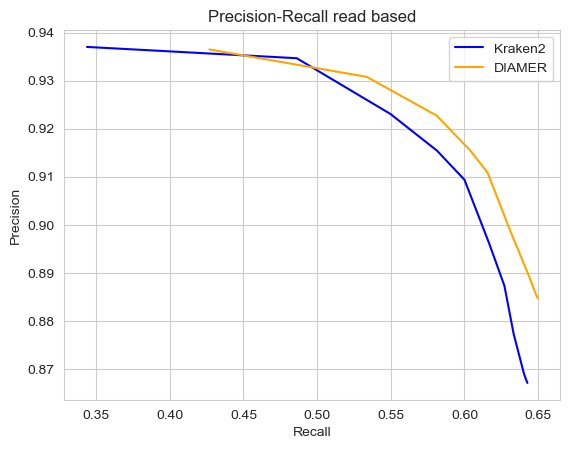

In [66]:
plt.plot(data_kraken["recall"], data_kraken["precision"], label="Kraken2", color="blue")
plt.plot(data_diamer["recall"], data_diamer["precision"], label="DIAMER", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall read based")
plt.legend()
plt.show()